In [ ]:
####### Reference: #######
## https://attyuttam.medium.com/generative-adversarial-networks-using-pytorch-3ad31cc61ac8
## https://www.jovian.ai/ Exact notebook?
#########################

In [1]:
import os

import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

#Load the data

mnist = FashionMNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [2]:
# Viewing the data

img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

In [3]:
# When viewing the images we would like to de normalize it 
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


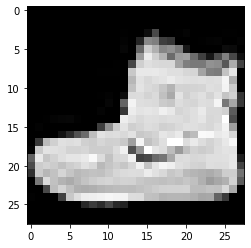

In [4]:
# View the image on screen

import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [5]:
from torch.utils.data import DataLoader

#To ensure that the data is loaded in batches during training we are using a DataLoader. 

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([1, 1, 3, 5, 6, 4, 8, 1, 2, 1, 0, 5, 5, 7, 1, 9, 2, 2, 6, 8, 1, 6, 4, 7,
        5, 3, 7, 9, 0, 1, 5, 7, 5, 8, 1, 2, 1, 2, 5, 2, 6, 5, 1, 4, 7, 4, 7, 4,
        2, 6, 6, 0, 1, 5, 8, 1, 4, 9, 7, 5, 0, 4, 8, 1, 1, 0, 5, 4, 2, 1, 9, 3,
        7, 9, 2, 2, 5, 4, 7, 3, 2, 1, 7, 1, 8, 0, 0, 0, 4, 8, 1, 0, 3, 3, 9, 5,
        2, 6, 4, 5])


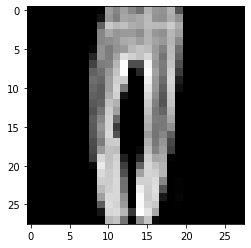

In [6]:
# In this block we are trying to print all the images in a batch
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [7]:
image_size = 784
hidden_size = 256
latent_size = 64

In [8]:
import torch.nn as nn

# Define a pretty simple Disriminator network which has:
# 1. Linear layer which takes in an input of image_size as 784 and hidden size 256
# 2. The output of the linear layer is passed through a ReLU activation function
# 3. The result of the activation function is then passed through a Linear layer which takes in 256 input and produces 256 outputs
# 4. This result is again passed through a leaky relu layer.
# 5. Finally the output is passed through a Linear layer and the result is passed through the sigmoid function.

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [9]:
# Define a pretty simple Generator network which has:
# 1. Linear layer which takes in an input of image_size as 64 and hidden size 256
# 2. The output of the linear layer is passed through a ReLU activation function
# 3. The result of the activation function is then passed through a Linear layer which takes in 256 input and produces 256 outputs
# 4. This result is again passed through a leaky relu layer.
# 5. Finally the output is passed through a Linear layer and the result is passed through the tanh() function.

G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [10]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

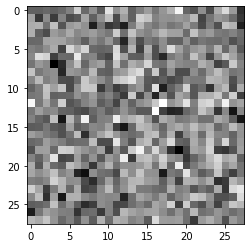

In [11]:
plt.imshow(gen_imgs[0], cmap='gray');

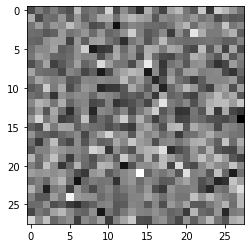

In [12]:
plt.imshow(gen_imgs[1], cmap='gray');

In [13]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [14]:
# Training the discriminator

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images, d_loss_old=-1):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1) # .to(device)
    fake_labels = torch.zeros(batch_size, 1) # .to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size) # .to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs
    
    # So essentially, you use the given set of real images and feed it to the discriminator and train to understand the pattern of the real images.
    # Then, you generate a bunch of fake images and then feed them to the discriminator to train them to understand the pattern of the fake images.

    # Combine losses
    d_loss = d_loss_real + d_loss_fake

    # # Reset gradients
    # reset_grad()
    # # Compute gradients
    # d_loss.backward()
    # # Adjust the parameters using backprop
    # d_optimizer.step()
    # print(d_loss.item(), d_loss_old, d_loss.item() > d_loss_old)
    if d_loss.item() > d_loss_old:
    # if d_loss_old == -1 or d_loss > d_loss_old:
        # Reset gradients
        reset_grad()
        # Compute gradients
        d_loss.backward()
        # Adjust the parameters using backprop
        d_optimizer.step()

    return d_loss, real_score, fake_score

In [15]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [16]:
def train_generator(g_loss_old=-1):
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size) # .to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1)  # .to(device)
    g_loss = criterion(D(fake_images), labels)

    # # Backprop and optimize
    # reset_grad()
    # g_loss.backward()
    # g_optimizer.step()
    # print(g_loss)
    # print(g_loss.item(), g_loss_old, g_loss.item() > g_loss_old)
    if g_loss.item() > g_loss_old:
    # if g_loss_old == -1 or g_loss > g_loss_old:
        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
    return g_loss, fake_images

In [17]:
### For GAN ###
sample_dir = 'samples_fmnist_gan'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

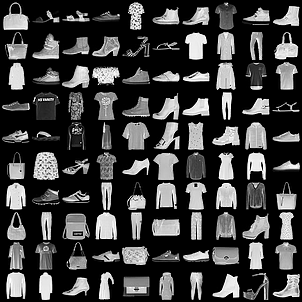

In [18]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


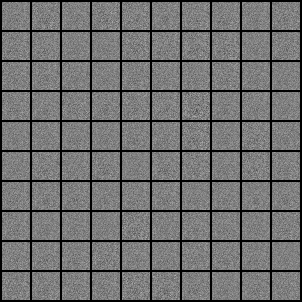

In [19]:
sample_vectors = torch.randn(batch_size, latent_size) # .to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [20]:
%%time

### GAN training ###
num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1)  # .to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        real_scores.append(real_score.mean().item())
        fake_scores.append(fake_score.mean().item())
        
    print('Epoch [{}/{}],  d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
          .format(epoch, num_epochs, d_loss.item(), g_loss.item(), 
                  real_score.mean().item(), fake_score.mean().item()))        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300],  d_loss: 0.0418, g_loss: 5.1111, D(x): 0.98, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300],  d_loss: 0.0216, g_loss: 5.4410, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0002.png
Epoch [2/300],  d_loss: 0.0202, g_loss: 7.3495, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0003.png
Epoch [3/300],  d_loss: 0.0364, g_loss: 7.7140, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0004.png
Epoch [4/300],  d_loss: 0.1221, g_loss: 9.0981, D(x): 0.97, D(G(z)): 0.00
Saving fake_images-0005.png
Epoch [5/300],  d_loss: 0.0640, g_loss: 5.9472, D(x): 0.98, D(G(z)): 0.03
Saving fake_images-0006.png
Epoch [6/300],  d_loss: 0.0794, g_loss: 5.7419, D(x): 0.97, D(G(z)): 0.02
Saving fake_images-0007.png
Epoch [7/300],  d_loss: 0.2007, g_loss: 5.9445, D(x): 0.95, D(G(z)): 0.08
Saving fake_images-0008.png
Epoch [8/300],  d_loss: 0.1968, g_loss: 5.1134, D(x): 0.94, D(G(z)): 0.04
Saving fake_images-0009.png
Epoch [9/300],  d_loss: 0.3474, g_loss: 4.7151, D(x): 0.92, D(G(z)): 0.10
Saving f

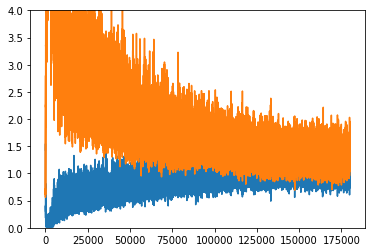

In [21]:
plt.ylim([0,4])
plt.plot(d_losses)
plt.plot(g_losses)

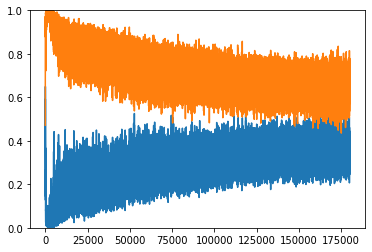

In [22]:
plt.ylim([0,1])
plt.plot(fake_scores)
plt.plot(real_scores)

In [17]:
## For CGN ##
sample_dir = 'samples_fmnist_cgn'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

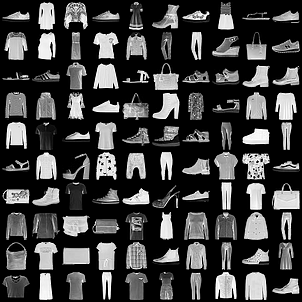

In [18]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


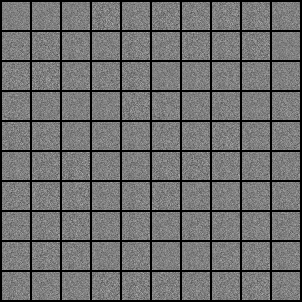

In [19]:
sample_vectors = torch.randn(batch_size, latent_size) # .to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [20]:
%%time

## CGN training ##
num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

g_loss_old, d_loss_old = 0, 0

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1)  # .to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images, d_loss_old)
        d_loss_old =  d_loss.item()
        g_loss, fake_images = train_generator(g_loss_old)
        g_loss_old =  g_loss.item()
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        real_scores.append(real_score.mean().item())
        fake_scores.append(fake_score.mean().item())
        
    print('Epoch [{}/{}],  d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
          .format(epoch, num_epochs, d_loss.item(), g_loss.item(), 
                  real_score.mean().item(), fake_score.mean().item()))        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300],  d_loss: 0.3417, g_loss: 1.9150, D(x): 0.85, D(G(z)): 0.15
Saving fake_images-0001.png
Epoch [1/300],  d_loss: 0.1548, g_loss: 2.8599, D(x): 0.93, D(G(z)): 0.06
Saving fake_images-0002.png
Epoch [2/300],  d_loss: 0.1264, g_loss: 2.9321, D(x): 0.98, D(G(z)): 0.09
Saving fake_images-0003.png
Epoch [3/300],  d_loss: 0.0937, g_loss: 3.3283, D(x): 0.97, D(G(z)): 0.05
Saving fake_images-0004.png
Epoch [4/300],  d_loss: 0.0281, g_loss: 4.2688, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0005.png
Epoch [5/300],  d_loss: 0.0308, g_loss: 5.8924, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0006.png
Epoch [6/300],  d_loss: 0.0434, g_loss: 4.4048, D(x): 0.98, D(G(z)): 0.02
Saving fake_images-0007.png
Epoch [7/300],  d_loss: 0.1161, g_loss: 4.7811, D(x): 0.95, D(G(z)): 0.03
Saving fake_images-0008.png
Epoch [8/300],  d_loss: 0.1220, g_loss: 4.5036, D(x): 0.97, D(G(z)): 0.05
Saving fake_images-0009.png
Epoch [9/300],  d_loss: 0.1772, g_loss: 3.1749, D(x): 0.95, D(G(z)): 0.09
Saving f

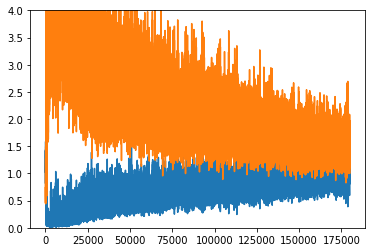

In [21]:
plt.ylim([0,4])
plt.plot(d_losses)
plt.plot(g_losses)

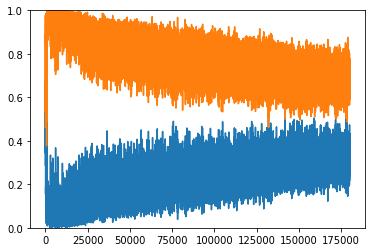

In [22]:
plt.ylim([0,1])
plt.plot(fake_scores)
plt.plot(real_scores)